In [1]:
import os, time, math, struct, argparse
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import entropy
import tqdm

from python.VQVAE_v2 import *

device = "cuda"
BATCH_SIZE = 2048
NUM_EMBEDDINGS = 128

In [2]:
data_dir   = r"C:/Users/zphrfx/Desktop/hdk/VQVDB/data/vdb_cache/mix/npy"
model_path = r"C:/Users/zphrfx/Desktop/hdk/VQVDB/python/models/vqvae_scripted.pt"

model = torch.jit.load(model_path, map_location=device).eval()

npy_files = list(Path(data_dir).glob("*.npy"))
dataset   = VDBLeafDataset(npy_files, include_origins=False, in_channels=1)
dataset   = torch.utils.data.Subset(dataset, range(0, len(dataset), 16))

train_sz = int(0.2 * len(dataset))
val_sz   = len(dataset) - train_sz
_, val_ds = torch.utils.data.random_split(dataset, [train_sz, val_sz])

print(f"Validation blocks: {len(val_ds)}")
print(model)

Validation blocks: 345929
RecursiveScriptModule(
  original_name=VQVAE
  (encoder): RecursiveScriptModule(
    original_name=EncoderFloat
    (pre): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=GroupNorm)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(
        original_name=ResidualBlock
        (gn1): RecursiveScriptModule(original_name=GroupNorm)
        (conv1): RecursiveScriptModule(original_name=Conv3d)
        (gn2): RecursiveScriptModule(original_name=GroupNorm)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv3d)
      )
    )
    (down): RecursiveScriptModule(original_name=Conv3d)
    (res_stack): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=ResidualBlock
        (gn1): RecursiveScriptModule(original_

In [3]:
@torch.no_grad()
def run_once(dataloader):
    """Returns dict with everything we need later."""
    out = {
        "orig" : [],          # original blocks (np.float32)
        "rec"  : [],          # reconstructed blocks
        "idx"  : [],          # codebook indices (int32)
        "mse"  : [],          # per-block MSE
        "psnr" : [],          # per-block PSNR
        "lat"  : [],          # per-block mean latent vector
    }

    for batch in tqdm(dataloader, desc="Forward pass"):
        x = batch.to(device)
        idx = model.encode(x)                       # (B, Z, Y, X)
        rec = model.decode(idx)

        # --- metrics ---
        mse = ((x - rec) ** 2).view(x.size(0), -1).mean(1)
        psnr = 20 * math.log10(1.0) - 10 * torch.log10(mse + 1e-12)

        # --- latent vector (mean over spatial dims) ---
        emb = model.quantizer.embedding[idx.view(-1)].view(*idx.shape, -1)  # (B,Z,Y,X,C)
        mean_lat = emb.mean(dim=(1, 2, 3))                                  # (B,C)

        out["orig"].append(x.cpu().numpy())
        out["rec"].append(rec.cpu().numpy())
        out["idx"].append(idx.cpu().numpy())
        out["mse"].append(mse.cpu().numpy())
        out["psnr"].append(psnr.cpu().numpy())
        out["lat"].append(mean_lat.cpu().numpy())

    # concatenate lists → numpy arrays
    for k in out:
        out[k] = np.concatenate(out[k])
    return out

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
cache = run_once(val_loader)
print("Single-pass complete.")

Forward pass: 100%|██████████| 169/169 [00:34<00:00,  4.87it/s]


Single-pass complete.


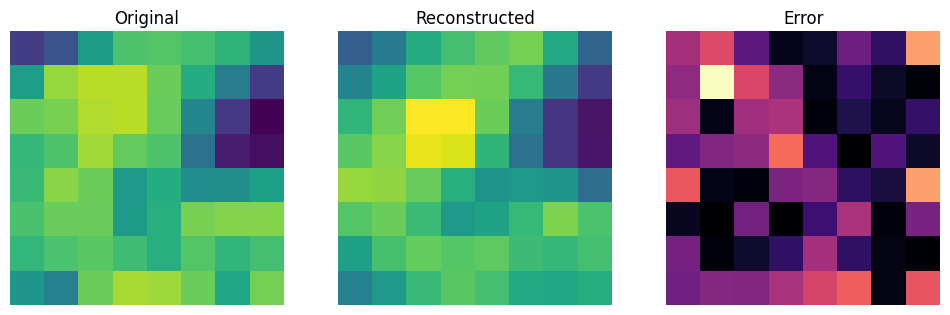

In [11]:
i = 543 % len(val_ds)   # pick a deterministic block
orig = cache["orig"][i].squeeze()
rec  = cache["rec"][i].squeeze()
err  = np.abs(orig - rec)

vmin, vmax = orig.min(), orig.max()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(orig[4], vmin=vmin, vmax=vmax, cmap='viridis'); ax[0].set_title("Original")
ax[1].imshow(rec[4],  vmin=vmin, vmax=vmax, cmap='viridis'); ax[1].set_title("Reconstructed")
ax[2].imshow(err[4], cmap='magma');                          ax[2].set_title("Error")
for a in ax: a.axis("off")
plt.show()

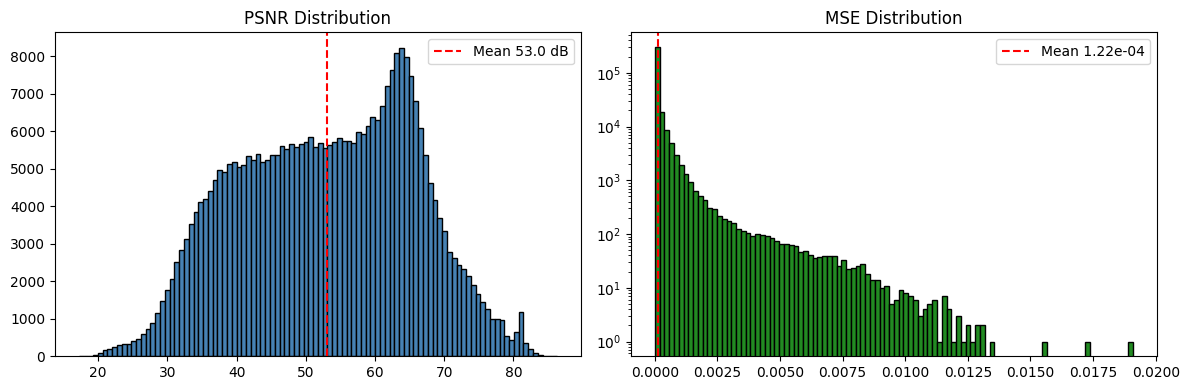

In [5]:
avg_mse  = cache["mse"].mean()
avg_psnr = cache["psnr"].mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(cache["psnr"], bins=100, color='steelblue', edgecolor='k')
ax[0].axvline(avg_psnr, color='r', ls='--', label=f"Mean {avg_psnr:.1f} dB")
ax[0].set_title("PSNR Distribution"); ax[0].legend()

ax[1].hist(cache["mse"], bins=100, color='forestgreen', edgecolor='k')
ax[1].axvline(avg_mse, color='r', ls='--', label=f"Mean {avg_mse:.2e}")
ax[1].set_yscale('log')
ax[1].set_title("MSE Distribution"); ax[1].legend()
plt.tight_layout(); plt.show()

In [ ]:
# --- codebook PCA ---
codebook = model.quantizer.embedding.data.cpu()
pca_cb = PCA(n_components=2).fit_transform(codebook)
plt.figure(figsize=(6, 6))
plt.scatter(pca_cb[:, 0], pca_cb[:, 1], s=15, alpha=.7)
plt.title("Codebook PCA"); plt.grid(True); plt.show()

# --- latent space PCA (coloured by MSE) ---
latents = cache["lat"]
lat_2d  = FastICA(n_components=2, random_state=0).fit_transform(latents)
plt.figure(figsize=(7, 7))
sc = plt.scatter(lat_2d[:, 0], lat_2d[:, 1], c=cache["mse"], s=4,
                 cmap='viridis', alpha=.8, norm=LogNorm())
plt.colorbar(sc, label='Block MSE')
plt.title("Latent Space (ICA-2D)"); plt.grid(True); plt.show()

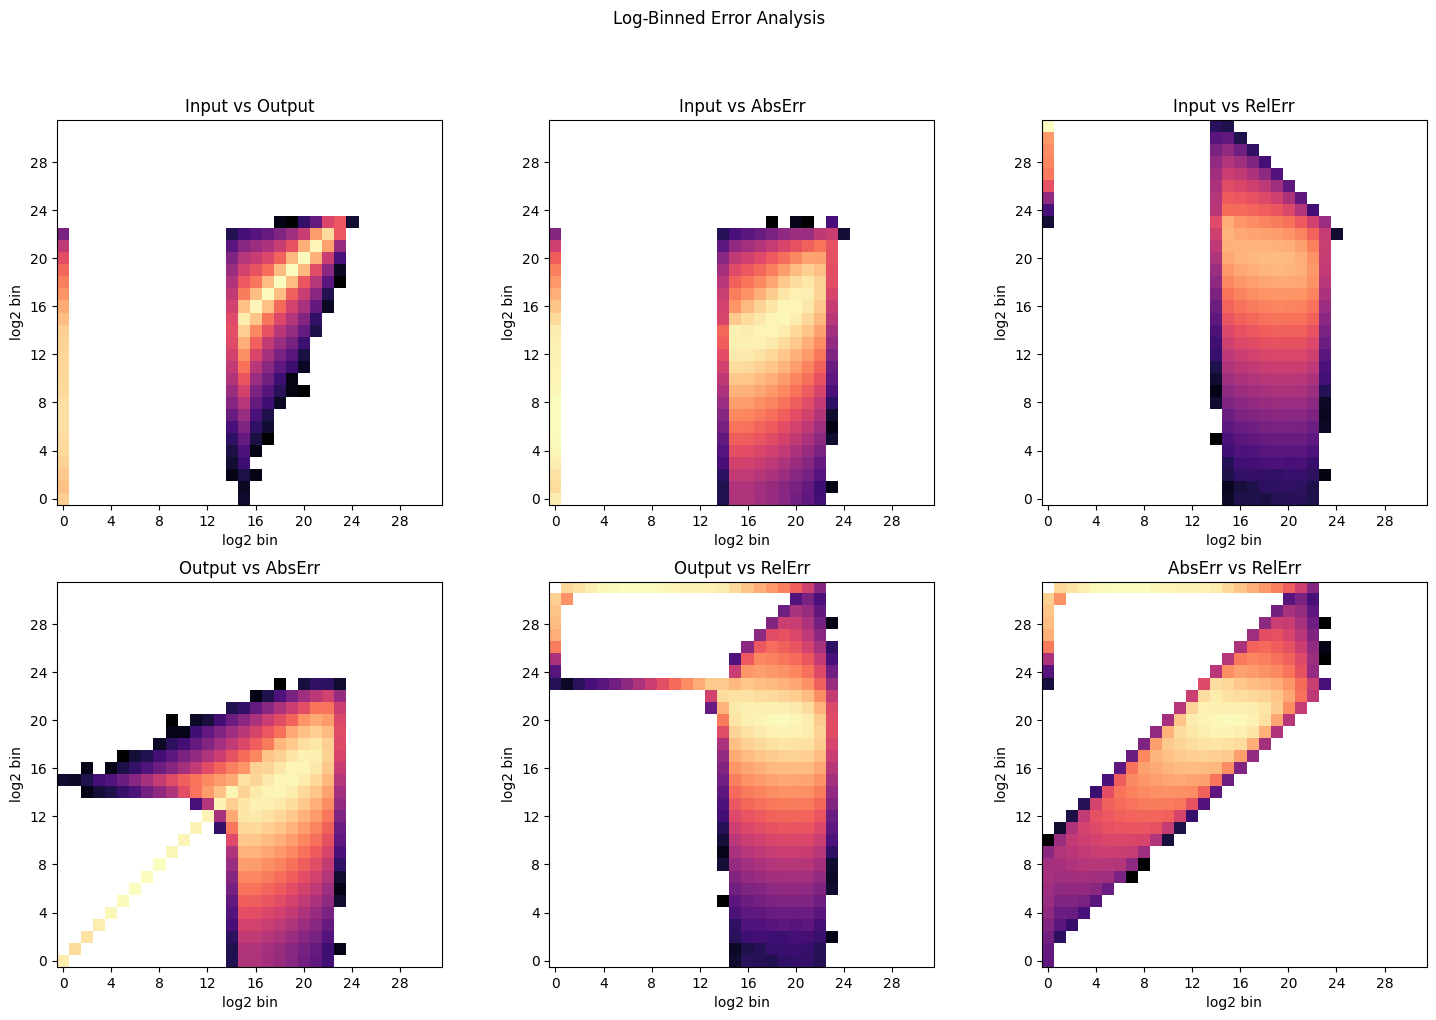

In [6]:
def log_bin(v):
    return np.clip(np.log2(np.abs(v) + 1e-30) + 24, 0, 31).astype(np.int32)

def lin_bin(v, n_bins=32):
    return np.clip(np.floor(v * n_bins), 0, n_bins-1).astype(int)

orig_flat = cache["orig"].flatten()
rec_flat  = cache["rec"].flatten()
abs_err   = np.abs(orig_flat - rec_flat)
rel_err   = abs_err / (np.abs(orig_flat) + 1e-9)

bins = np.arange(33) - .5
pairs = [
    (log_bin(orig_flat), log_bin(rec_flat),  "Input vs Output"),
    (log_bin(orig_flat), log_bin(abs_err),   "Input vs AbsErr"),
    (log_bin(orig_flat), log_bin(rel_err),   "Input vs RelErr"),
    (log_bin(rec_flat),  log_bin(abs_err),   "Output vs AbsErr"),
    (log_bin(rec_flat),  log_bin(rel_err),   "Output vs RelErr"),
    (log_bin(abs_err),   log_bin(rel_err),   "AbsErr vs RelErr"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()
for ax, (x, y, title) in zip(axes, pairs):
    h, *_ = np.histogram2d(x, y, bins=bins)
    ax.imshow(h.T, origin='lower', cmap='magma', norm=LogNorm(vmin=1))
    ax.set_title(title); ax.set_xlabel("log2 bin"); ax.set_ylabel("log2 bin")
    ax.set_xticks(np.arange(0, 32, 4)); ax.set_yticks(np.arange(0, 32, 4))
plt.suptitle("Log-Binned Error Analysis"); plt.show()

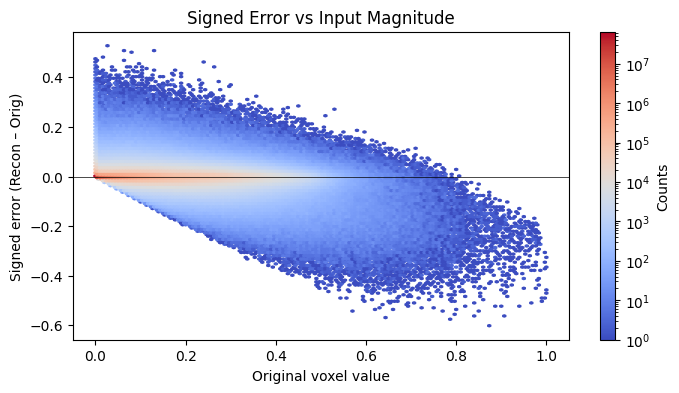

In [7]:
orig = cache["orig"].flatten()
rec  = cache["rec"].flatten()
signed_err = rec - orig

mag_bin = np.clip(np.log2(np.abs(orig) + 1e-30) + 24, 0, 31).astype(int)
df = np.column_stack((mag_bin, signed_err))

plt.figure(figsize=(8,4))
plt.hexbin(orig, signed_err, gridsize=150, cmap='coolwarm', norm=LogNorm())
plt.colorbar(label='Counts')
plt.axhline(0, color='k', lw=.5)
plt.xlabel('Original voxel value')
plt.ylabel('Signed error (Recon – Orig)')
plt.title('Signed Error vs Input Magnitude')
plt.show()

C:\Users\zphrfx\AppData\Local\Temp\ipykernel_18092\571290054.py:5: RuntimeWarning: Mean of empty slice.
  mse_q.append(((rec[mask] - orig[mask])**2).mean())
c:\Users\zphrfx\Desktop\hdk\VQVDB\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


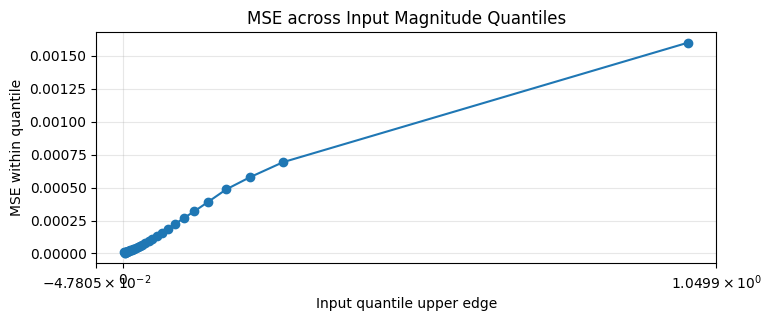

In [8]:
q_edges = np.quantile(orig, np.linspace(0, 1, 50))   # 10 quantiles
mse_q = []
for lo, hi in zip(q_edges[:-1], q_edges[1:]):
    mask = (orig >= lo) & (orig < hi)
    mse_q.append(((rec[mask] - orig[mask])**2).mean())

plt.figure(figsize=(8,3))
plt.plot(q_edges[1:], mse_q, marker='o')
plt.xscale('symlog')
plt.xlabel('Input quantile upper edge')
plt.ylabel('MSE within quantile')
plt.title('MSE across Input Magnitude Quantiles')
plt.grid(True, alpha=.3)
plt.show()

In [9]:
mask_zero = orig == 0
zero_mse  = ((rec - orig)[mask_zero]**2).mean()
nonzero_mse = ((rec - orig)[~mask_zero]**2).mean()

print(f"MSE on zero-valued voxels:   {zero_mse:.2e}")
print(f"MSE on non-zero voxels:      {nonzero_mse:.2e}")

MSE on zero-valued voxels:   1.21e-05
MSE on non-zero voxels:      1.79e-04
